In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [3]:
def preprocess_data(df, cell_line_indices):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    unique_cell_lines = df_copy['cell_line'].unique()
    selected_cell_lines = unique_cell_lines[cell_line_indices]  # Select by indices

    df_subset = df_copy[df_copy['cell_line'].isin(selected_cell_lines)]

    # Pivot as before
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the original selection order
    pivoted = pivoted.loc[selected_cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

# list_cell_lines = [3, 13, 81, 25, 54, 74, 97, 40]
list_cell_lines = [3, 29, 81]
list_cell_lines = [88, 29, 81]
# list_cell_lines = [83, 29, 81]
# list_cell_lines = range(60)
x, Y = preprocess_data(df, list_cell_lines)

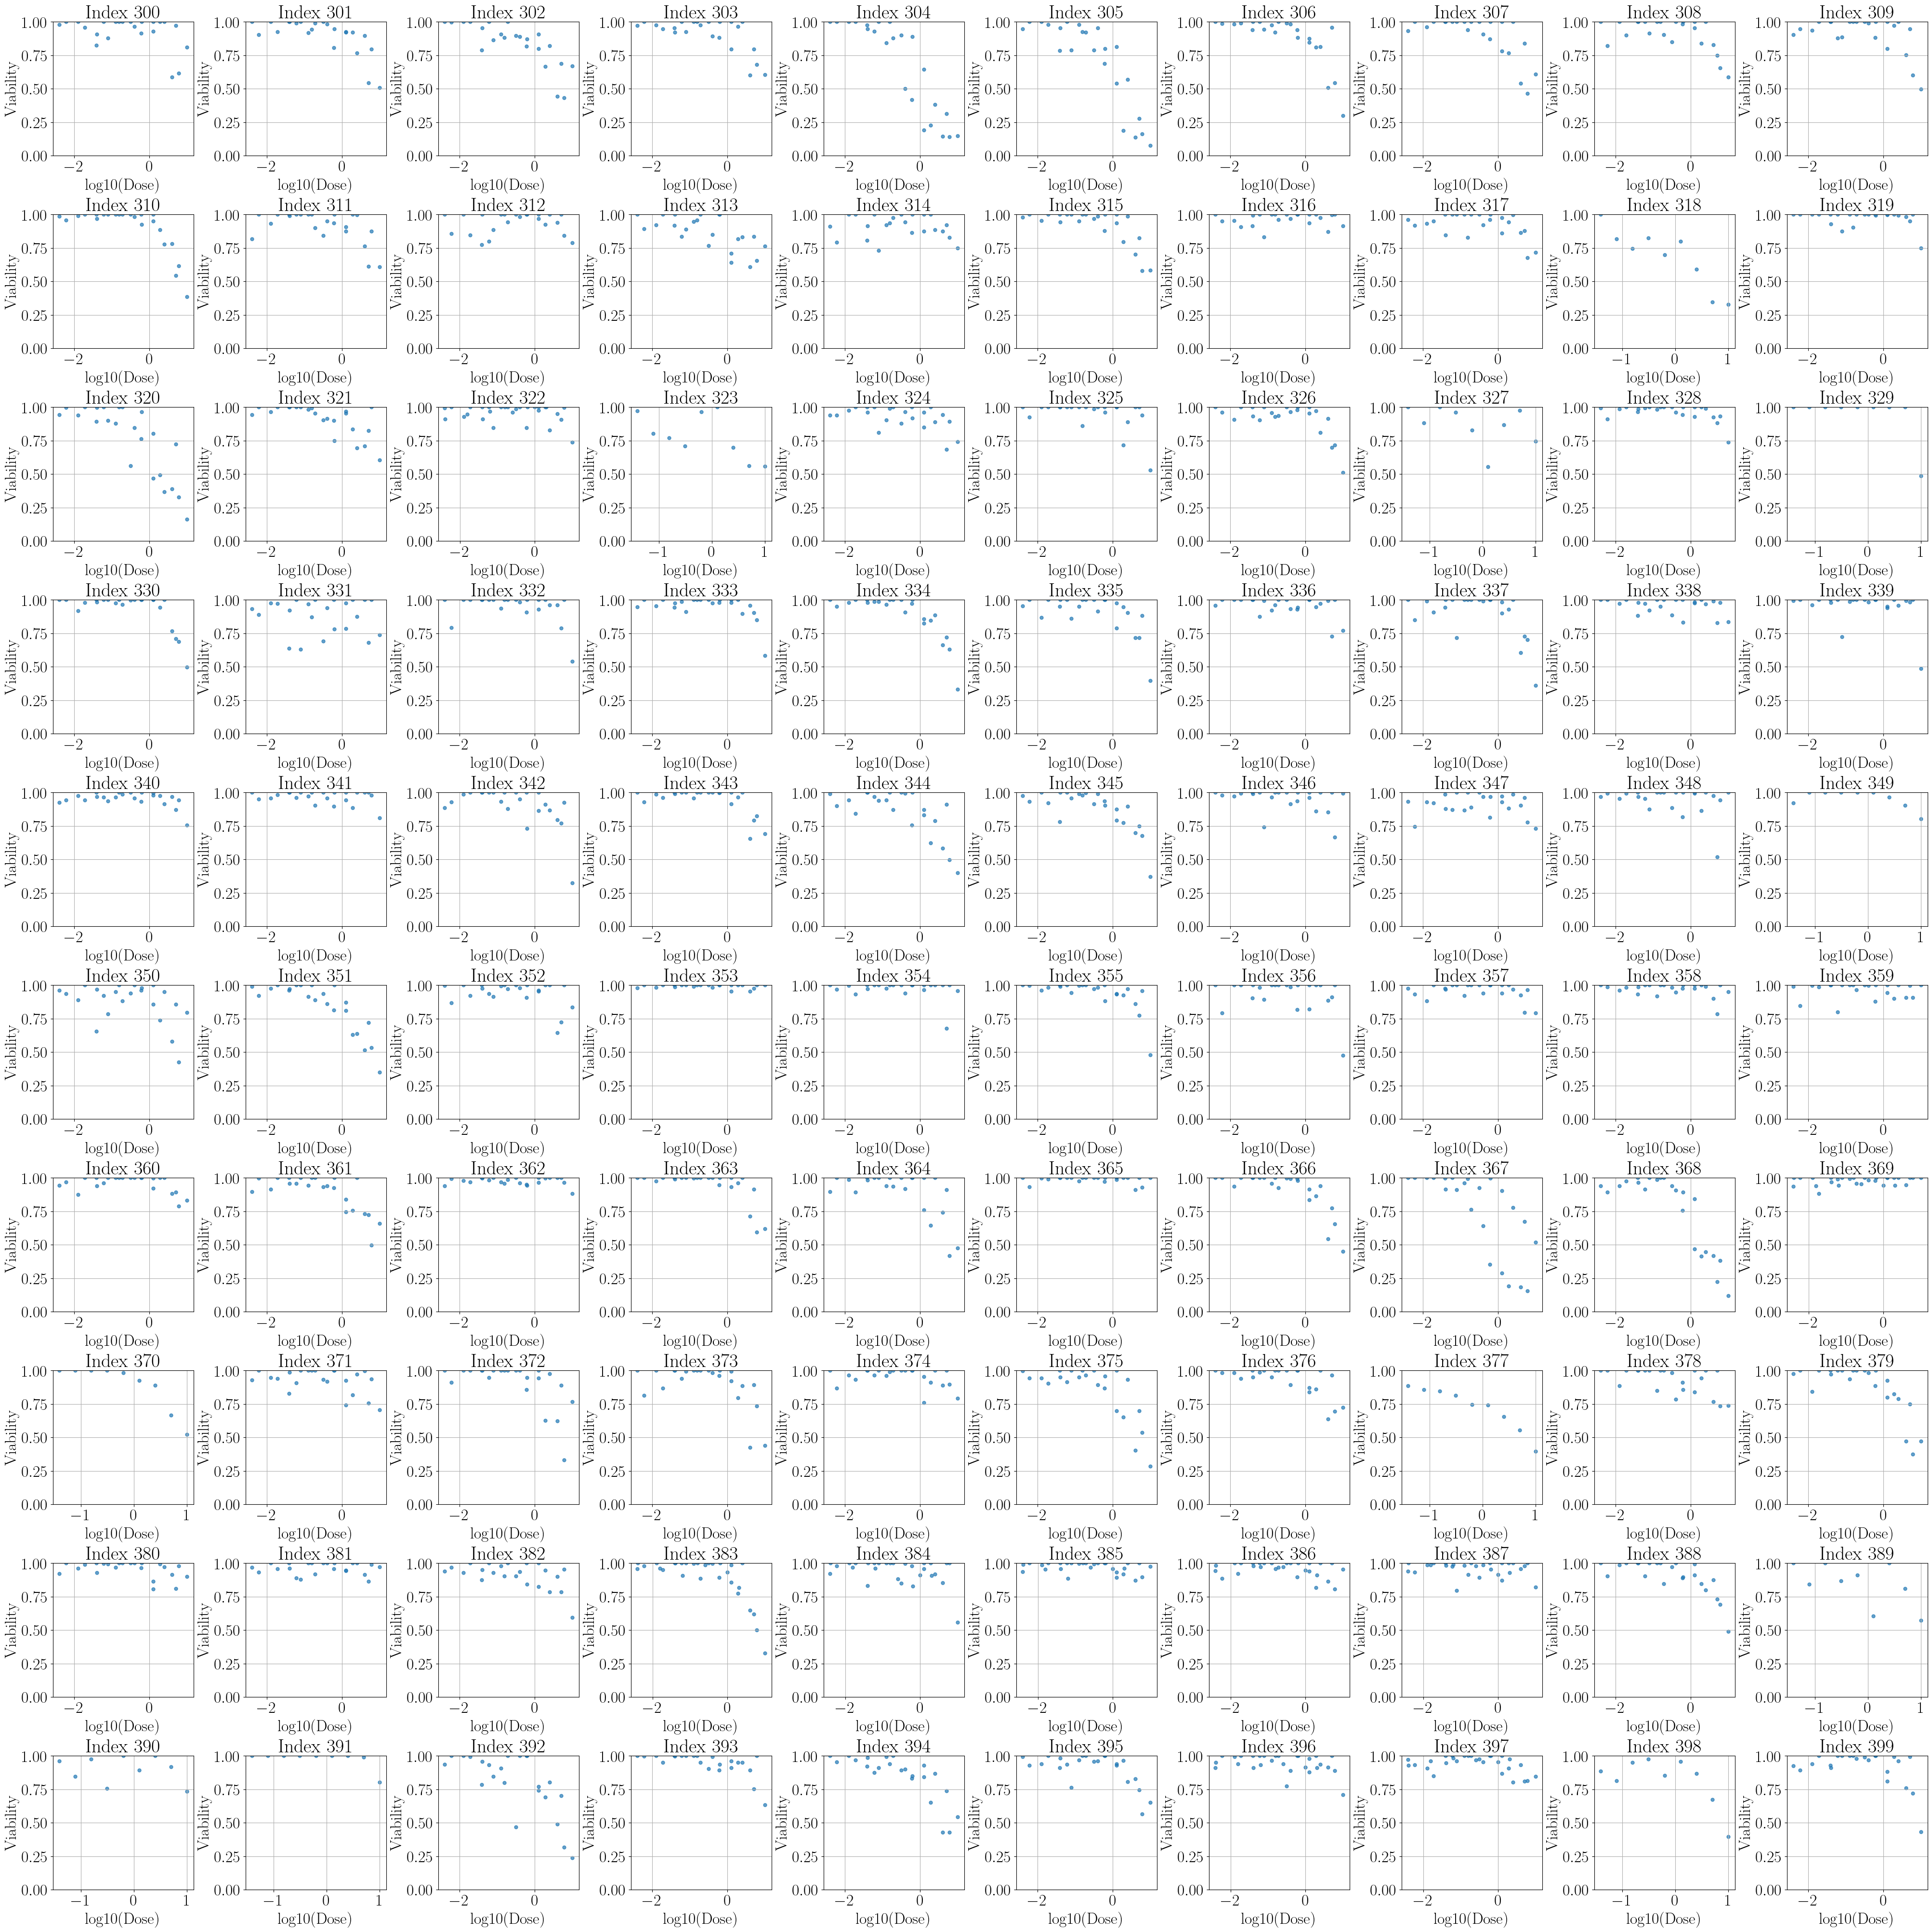

In [33]:
def visual_examples(df, k, begin_idx):
    unique_cell_lines = df['cell_line'].unique()
    k = min(k, len(unique_cell_lines))  # avoid indexing error

    # Calculate number of rows and columns for the grid
    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(k):
        cell_line = unique_cell_lines[begin_idx + i]
        df_n = df[df['cell_line'] == cell_line]

        ax = axes[i]
        ax.scatter(df_n['log10_dose'], df_n['viability'], alpha=0.7)
        ax.set_title(f'Index {begin_idx + i}')
        ax.set_xlabel('log10(Dose)')
        ax.set_ylabel('Viability')
        ax.grid(True)

        ax.set_ylim(0, 1)

    # Hide any unused subplots
    for j in range(k, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

visual_examples(df, 100, 300)

In [4]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

## MOGP

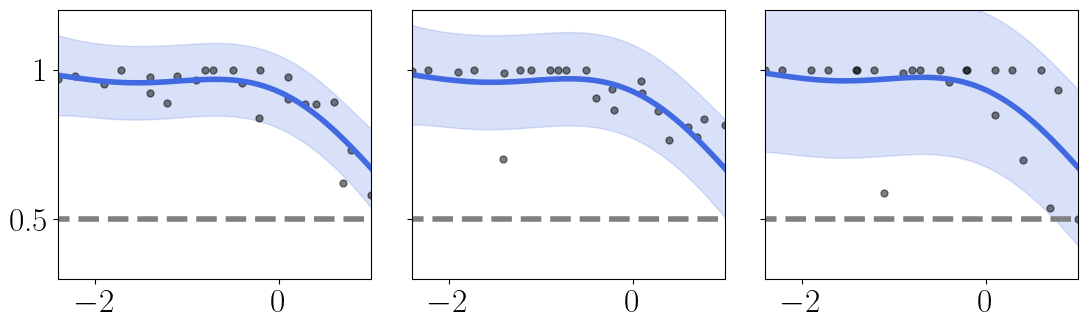

In [5]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = np.array([0.1, 0.1, 0.1]) 
init_A = generate_A(d=n_outputs, r=2, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
# mogp = MOGPRegressor_NC(mean=prior_mean, length_scale=init_length_scale, noise=0.01, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

## MORCGP

Optimized length_scale: 1.9313
Optimized noise: [0.00347567 0.00588143 0.01623213]
Optimized A: [[0.12774795 0.35118691]
 [0.13089    0.35982719]
 [0.13192625 0.36267799]]
Optimized B: 
[[0.13965179 0.14308753 0.14422107]
 [0.14308753 0.1466078  0.14776923]
 [0.14422107 0.14776923 0.14893986]]


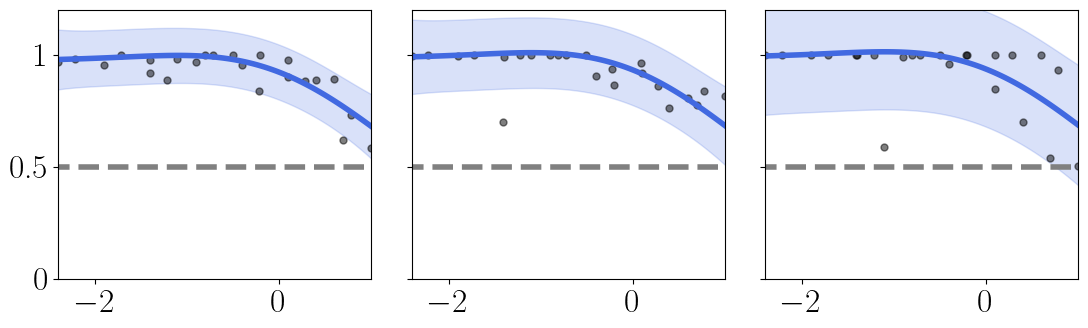

In [6]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_A = np.array([
    [0.19999236, 0.18617754, 0.19758124, 0.19932977],
    [0.19201191, 0.17874885, 0.18969746, 0.19137673],
    [0.18925192, 0.17617919, 0.18697063, 0.18862537],
    [0.20740665, 0.19307958, 0.20490645, 0.20671954]
])

# Instantiate and train
# morcgp = MORCGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = optim_noise, A=optim_A)
# morcgp = MORCGPRegressor_NC(mean = prior_mean, length_scale=init_length_scale, noise = optim_noise, A=optim_A)
# predictive_means, predictive_variances = morcgp.fit(x, Y)

morcgp = MORCGPRegressor_fixed_weights(mean=prior_mean, length_scale=init_length_scale, noise=optim_noise, A=optim_A)
# morcgp = MORCGPRegressor_NC_fixed_weights(mean=prior_mean, length_scale=optim_length_scale, noise=optim_noise, A=optim_A)
predictive_means, predictive_variances = morcgp.fit(x, Y, optim_B, optim_noise)

# Optimize hyperparameters
predictive_means, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, 
                    #    B_weighted=optim_B, 
                    #    noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

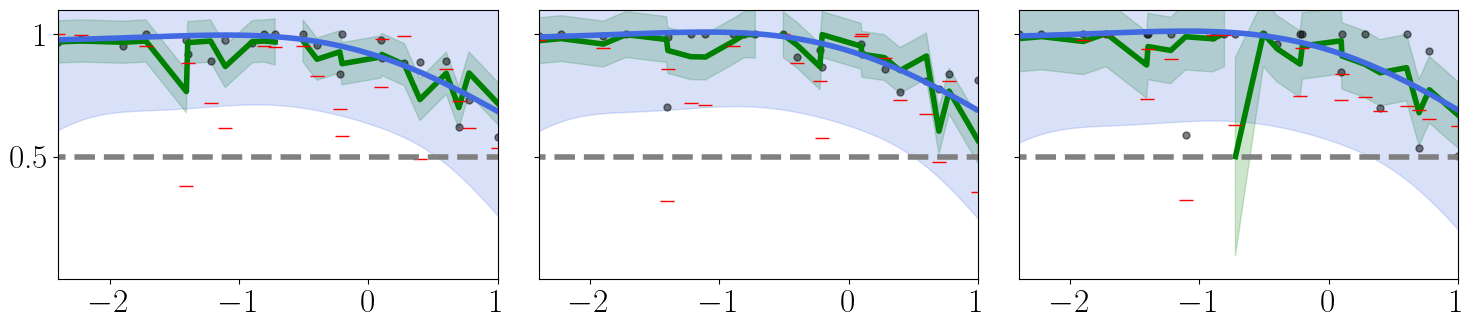

In [73]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(4 * 4, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='green', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), predictive_means[:, i] - np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + np.sqrt(predictive_variances)[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')
    axs[i].plot(x.flatten(), ((morcgp.w.reshape(n_outputs,-1).T/(morcgp.noise/2)**0.5))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

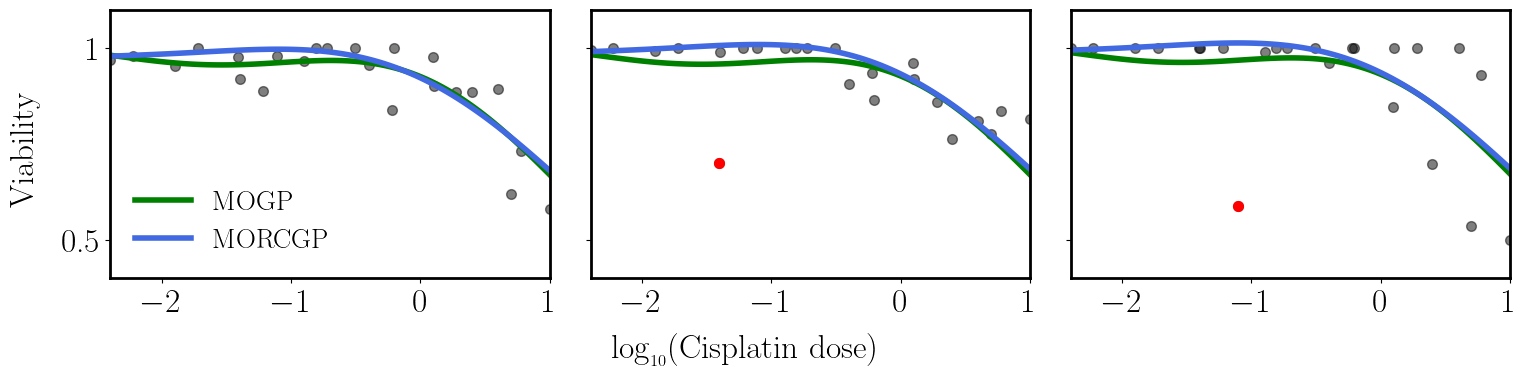

In [7]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # Dynamically adjust figure size

for i in range(3):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5, markersize=7)
    # axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP')
    axs[i].set_ylim([0.4, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
        legend = axs[i].legend(loc='lower left', frameon=True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('white')
        frame.set_alpha(1.0)  # Fully opaque
    else:
        axs[i].set_yticklabels([])  # Hide on all others

for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)

axs[1].plot(x.flatten()[4], Y[4, 1], 'o', color='red', markersize=7)
axs[2].plot(x.flatten()[7], Y[7, 2], 'o', color='red', markersize=7)

# Common axis labels
fig.text(0.5, 0.04, r'$\log_{\scriptscriptstyle 10}(\textrm{Cisplatin dose})$', ha='center', fontsize=24)
fig.text(0.04, 0.56, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

# fig.savefig("./cisplatin_MOGP.pdf", format='pdf', bbox_inches='tight')

## Multiple cell lines (>3)

In [5]:
list_cell_lines = [29, 81, 88, 11, 52, 83]
x, Y = preprocess_data(df, list_cell_lines)

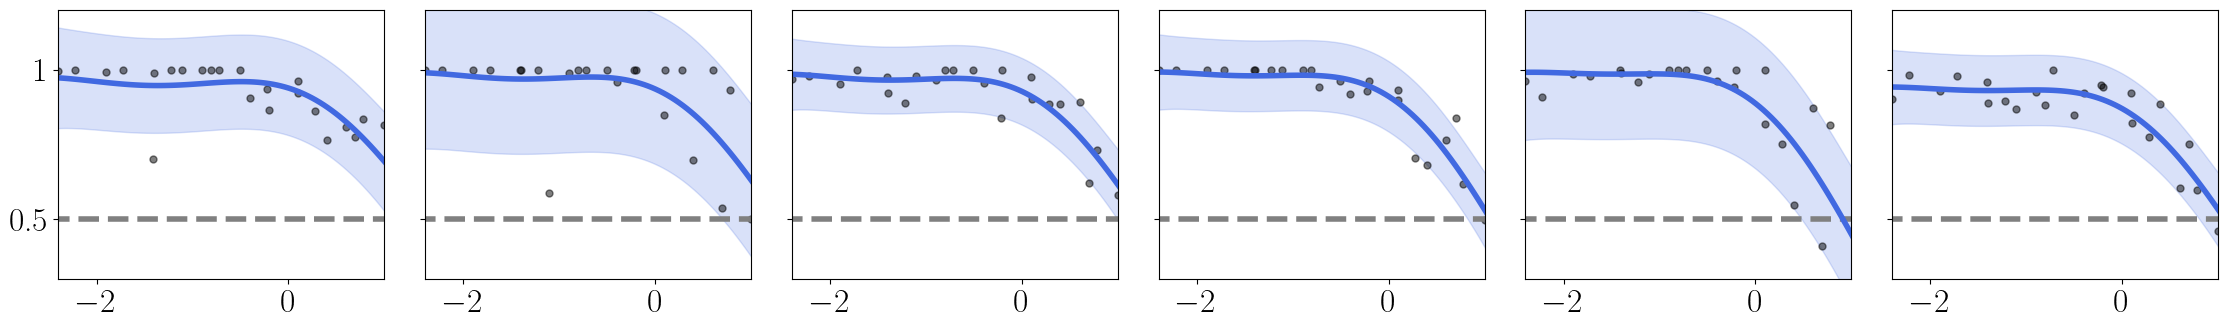

In [6]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = np.array([0.1]*n_outputs) 
init_A = generate_A(d=n_outputs, r=3, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
# mogp = MOGPRegressor_NC(mean=prior_mean, length_scale=init_length_scale, noise=0.01, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

Optimized length_scale: 1.9309
Optimized noise: [0.00590836 0.01572285 0.00298394 0.00332105 0.011552   0.0033569 ]
Optimized A: [[0.30307745 0.19930344 0.17206097]
 [0.29066206 0.2421288  0.22643346]
 [0.28178338 0.2428894  0.2293443 ]
 [0.26049502 0.29303695 0.29452507]
 [0.22937758 0.33199143 0.34843278]
 [0.23013958 0.25894325 0.26027041]]
Optimized B: 
[[0.16118278 0.17531058 0.17327208 0.18802971 0.19563789 0.16614078]
 [0.17531058 0.1943829  0.19264548 0.21335903 0.22595289 0.18852439]
 [0.17327208 0.19264548 0.19099594 0.21212638 0.22518306 0.18743562]
 [0.18802971 0.21335903 0.21212638 0.24047332 0.25965966 0.21248632]
 [0.19563789 0.22595289 0.22518306 0.25965966 0.28423779 0.22944255]
 [0.16614078 0.18852439 0.18743562 0.21248632 0.22944255 0.18775652]]


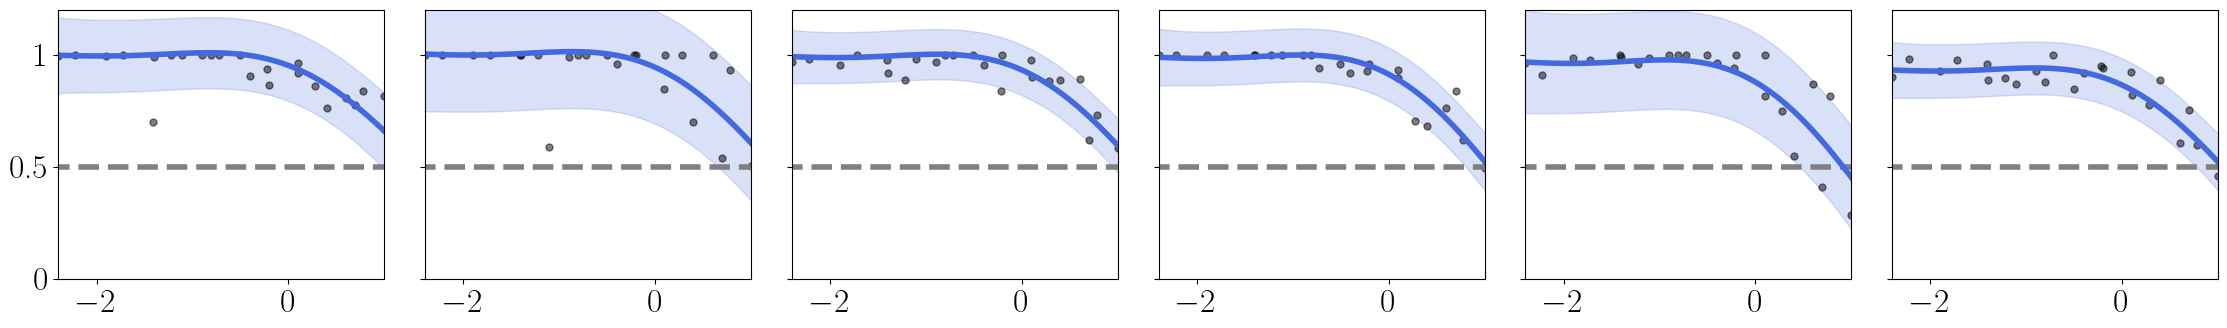

In [7]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_A = np.array([
    [0.19999236, 0.18617754, 0.19758124, 0.19932977],
    [0.19201191, 0.17874885, 0.18969746, 0.19137673],
    [0.18925192, 0.17617919, 0.18697063, 0.18862537],
    [0.20740665, 0.19307958, 0.20490645, 0.20671954]
])

# Instantiate and train
# morcgp = MORCGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = optim_noise, A=optim_A)
# morcgp = MORCGPRegressor_NC(mean = prior_mean, length_scale=init_length_scale, noise = optim_noise, A=optim_A)
# predictive_means, predictive_variances = morcgp.fit(x, Y)

morcgp = MORCGPRegressor_fixed_weights(mean=prior_mean, length_scale=init_length_scale, noise=optim_noise, A=optim_A)
# morcgp = MORCGPRegressor_NC_fixed_weights(mean=prior_mean, length_scale=optim_length_scale, noise=optim_noise, A=optim_A)
predictive_means, predictive_variances = morcgp.fit(x, Y, optim_B, optim_noise)

# Optimize hyperparameters
predictive_means, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, 
                    #    B_weighted=optim_B, 
                    #    noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

Optimized length_scale: 1.9308
Optimized noise: [0.00591389 0.01574036 0.0029872  0.00332512 0.01156745 0.00335851]
Optimized A: [[0.3030948  0.19814978 0.17066948]
 [0.2856296  0.24043512 0.22552323]
 [0.28544967 0.24605453 0.23232921]
 [0.26348739 0.2915988  0.29212477]
 [0.22385339 0.33161421 0.34921784]
 [0.23491757 0.26056444 0.26114982]]
Optimized B: 
[[0.16025786 0.17270494 0.17492546 0.18749868 0.19315891 0.16740338]
 [0.17270494 0.19025404 0.19308866 0.21125131 0.22242759 0.18864361]
 [0.17492546 0.19308866 0.1960012  0.21483071 0.22662756 0.19184293]
 [0.18749868 0.21125131 0.21483071 0.23979235 0.25769603 0.21416643]
 [0.19315891 0.22242759 0.22662756 0.25769603 0.28203142 0.23019214]
 [0.16740338 0.18864361 0.19184293 0.21416643 0.23019214 0.19127932]]


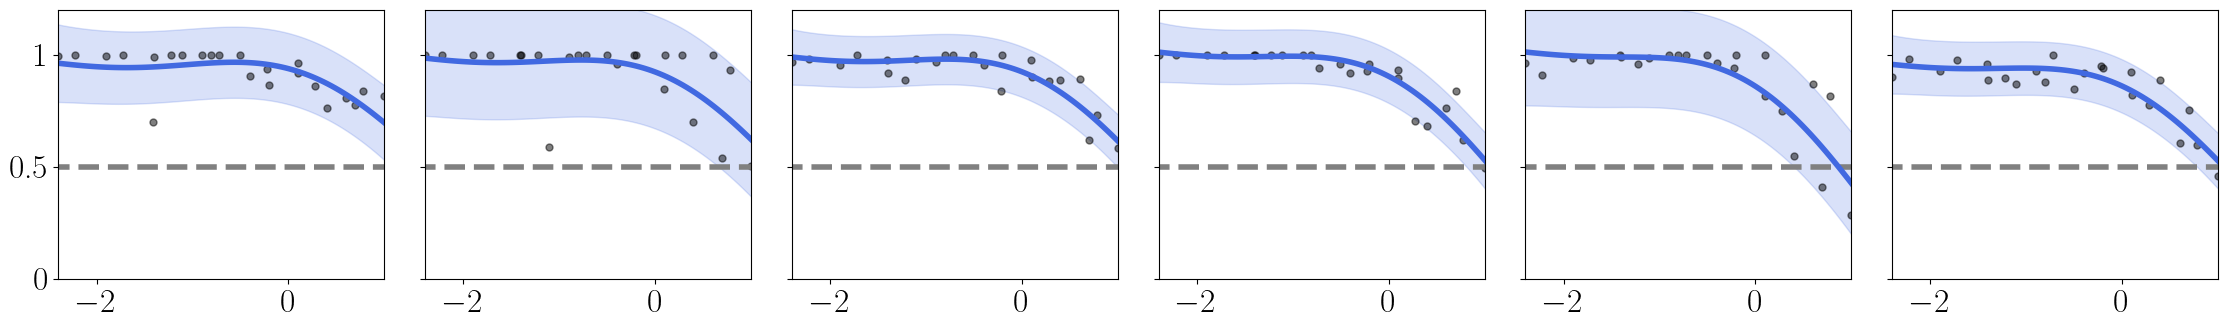

In [8]:
morcgp_pm = MORCGPRegressor_PM(mean=prior_mean, length_scale=init_length_scale, noise=optim_noise, A=optim_A, epsilons=np.array([1/23, 1/23, 0, 0, 0, 0]))
# morcgp = MORCGPRegressor_NC_fixed_weights(mean=prior_mean, length_scale=optim_length_scale, noise=optim_noise, A=optim_A)
morcgp_pm.fit(x, Y)

# Optimize hyperparameters
morcgp_pm.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, 
                    #    B_weighted=optim_B, 
                    #    noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_pm, var_pm = morcgp_pm.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp_pm.noise)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))  # Dynamically adjust figure size

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), predictive_means[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), predictive_means[:, i] - 2*np.sqrt(predictive_variances)[:, i], predictive_means[:, i] + 2*np.sqrt(predictive_variances)[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_pm[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0, 0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0', '0.5', '1'])  # Only show labels on the leftmost plot
    else:
        axs[i].set_yticklabels([])  # Hide on all others

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

In [9]:
weights_pm = morcgp_pm.w01_plot.reshape(6,-1).T
weights_morcgp = morcgp.w01_plot.reshape(6,-1).T

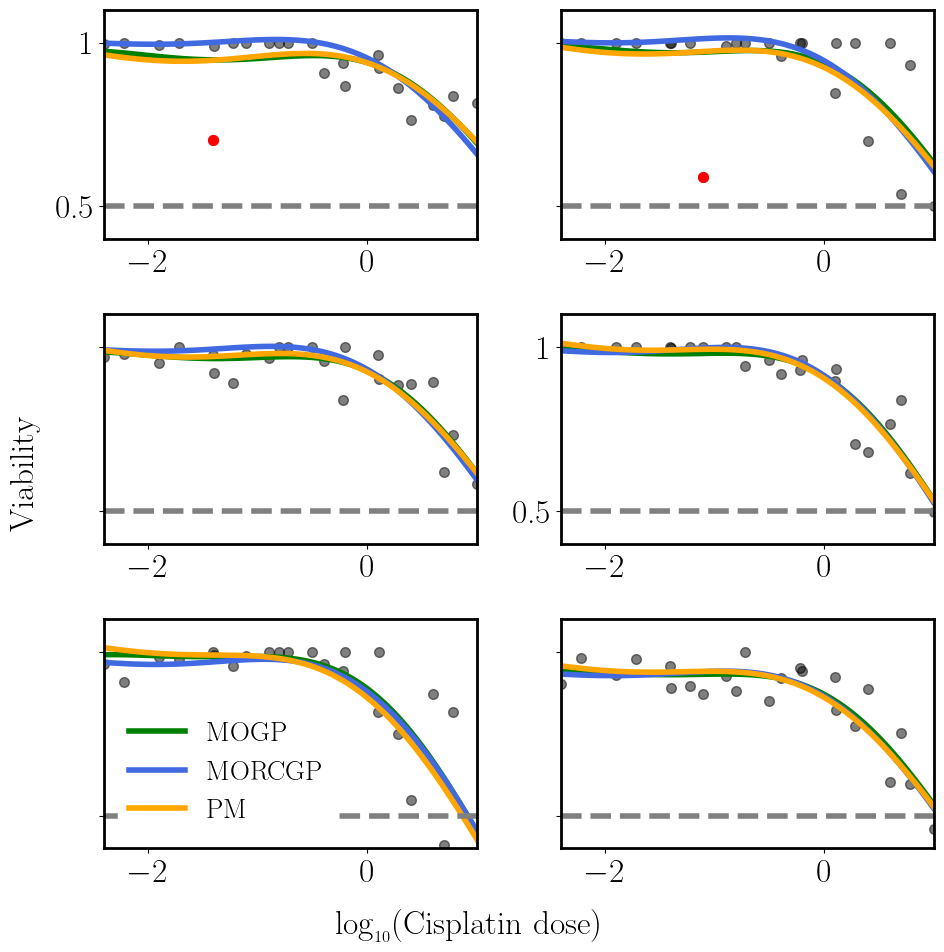

In [76]:
# Plotting
fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # 3x2 grid

axs = axs.flatten()  # Flatten to make it easy to loop through

for i in range(6):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5, markersize=7)
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP')
    axs[i].plot(x_test.flatten(), mu_pm[:, i], '-', color='orange', label='PM')
    
    # Add constant grey dashed line at y=0.5
    axs[i].axhline(y=0.5, color='grey', linestyle='--')

    axs[i].set_ylim([0.4, 1.1])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    # Show y-tick labels only on the leftmost plots (i % 3 == 0)
    if i % 3 == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])

    # Add legend to the first subplot only
    if i == 4:
        legend = axs[i].legend(loc='lower left', frameon=True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('white')
        frame.set_alpha(1.0)

    # Thicken borders
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)

# Example of highlighting specific points (optional, adjust as needed)
axs[0].plot(x.flatten()[4], Y[4, 0], 'o', color='red', markersize=7)
axs[1].plot(x.flatten()[7], Y[7, 1], 'o', color='red', markersize=7)

# Common axis labels
fig.text(0.5, 0.04, r'$\log_{\scriptscriptstyle 10}(\textrm{Cisplatin dose})$', ha='center', fontsize=24)
fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()



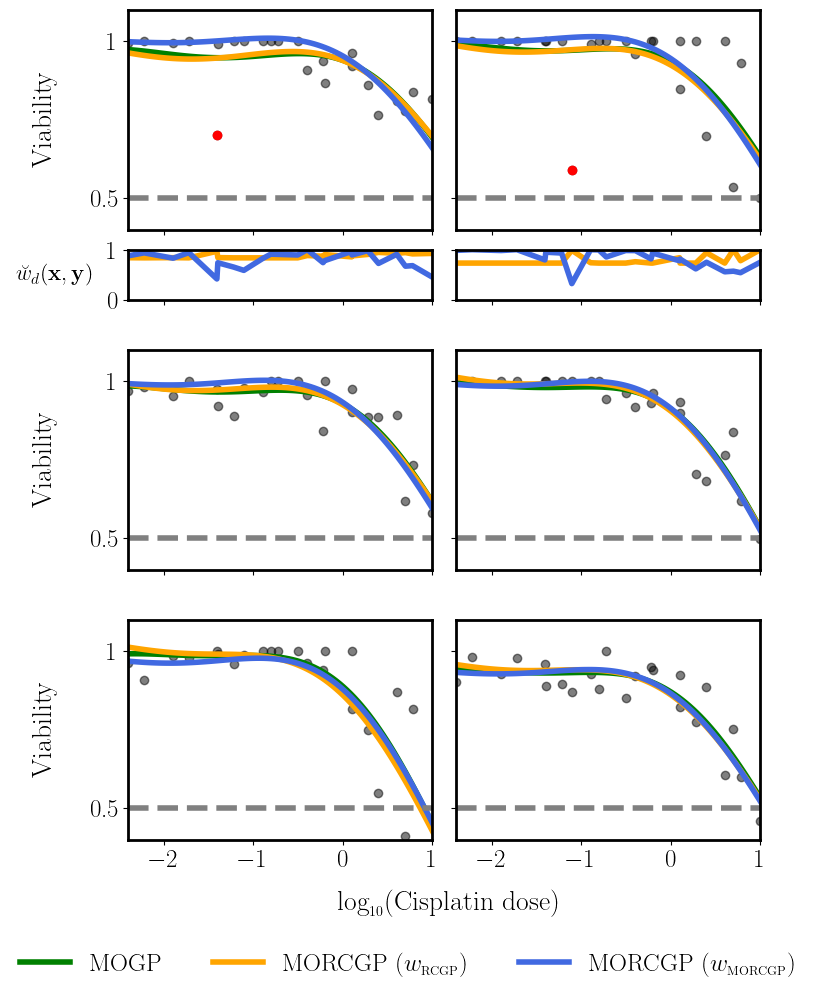

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 10))

# Define dimensions
left = 0.1
width = 0.38
hspace = 0.03  # horizontal space between left and right subplot columns

# Define row heights and vertical spacings manually
row_heights = [0.22, 0.05, 0.22, 0.22]  # Heights: row 0 (top) to row 3 (bottom)
row_spacings = [0.02, 0.05, 0.05]       # Vertical gaps between rows

# Calculate bottom positions for each row (from top to bottom)
bottoms = []
current_bottom = 1.0
for i in range(4):
    if i > 0:
        current_bottom -= row_spacings[i - 1]
    current_bottom -= row_heights[i]
    bottoms.append(current_bottom)

# Create subplots: 4 rows x 2 columns
axs = []
for row in range(4):
    for col in range(2):
        ax = fig.add_axes([
            left + col * (width + hspace),
            bottoms[row],
            width,
            row_heights[row]
        ])
        axs.append(ax)

# Helper function to plot ignoring NaNs by masking them
def plot_no_nan(ax, x, y, **kwargs):
    mask = ~np.isnan(y)
    ax.plot(x[mask], y[mask], **kwargs)

# Indices for output plots (leaving 2 and 3 for weights)
output_indices = [0, 1, 4, 5, 6, 7]

# Plot outputs
for plot_idx, data_idx in enumerate(range(6)):
    ax_idx = output_indices[plot_idx]
    axs[ax_idx].plot(x.flatten(), Y[:, data_idx], 'o', color='black', alpha=0.5, markersize=6)
    axs[ax_idx].plot(x_test.flatten(), mu_mogp[:, data_idx], '-', color='green', label='MOGP')
    axs[ax_idx].plot(x_test.flatten(), mu_pm[:, data_idx], '-', color='orange', label=r'MORCGP ($w_{\scriptscriptstyle \textup{RCGP}}$)')
    axs[ax_idx].plot(x_test.flatten(), mu_morcgp[:, data_idx], '-', color='royalblue', label=r'MORCGP ($w_{\scriptscriptstyle \textup{MORCGP}}$)')

    axs[ax_idx].axhline(y=0.5, color='grey', linestyle='--')
    axs[ax_idx].set_ylim([0.4, 1.1])
    axs[ax_idx].set_xlim([x[0], x[-1]])
    axs[ax_idx].set_yticks([0.5, 1])

    if ax_idx % 2 == 0:
        axs[ax_idx].set_yticklabels(['0.5', '1'])
    else:
        axs[ax_idx].set_yticklabels([])

    for spine in axs[ax_idx].spines.values():
        spine.set_linewidth(2)

# Hide x-tick labels for all but the last row
for i in range(4):
    axs[output_indices[i]].set_xticklabels([])

# Highlight points
axs[output_indices[0]].plot(x.flatten()[4], Y[4, 0], 'o', color='red', markersize=6)
axs[output_indices[1]].plot(x.flatten()[7], Y[7, 1], 'o', color='red', markersize=6)

# Plot weights (axs[2], axs[3]) ignoring NaNs
plot_no_nan(axs[2], x.flatten(), weights_pm[:, 0], color='orange')
plot_no_nan(axs[2], x.flatten(), weights_morcgp[:, 0], color='royalblue')

plot_no_nan(axs[3], x.flatten(), weights_pm[:, 1], color='orange')
plot_no_nan(axs[3], x.flatten(), weights_morcgp[:, 1], color='royalblue')

for i in [2, 3]:
    axs[i].set_ylim([0, 1])
    axs[i].set_xlim([x[0], x[-1]])
    # Set spine linewidth for weights axes (second row) to match others
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)

# Second row (weights) yticks & labels updated
axs[2].set_yticks([0, 1])
axs[3].set_yticks([0, 1])

axs[2].set_yticklabels(['0', '1'])
axs[3].set_yticklabels([])

axs[2].set_xticklabels([])
axs[3].set_xticklabels([])

# Shared axis labels with more padding (moved left from 0.04 to 0.02)
fig.text(0.5, 0.1, r'$\log_{\scriptscriptstyle 10}(\textrm{Cisplatin dose})$', ha='center', fontsize=20)
fig.text(-0.02, bottoms[0] + row_heights[0]/2, 'Viability', va='center', rotation='vertical', fontsize=20)
fig.text(-0.04, bottoms[1] + row_heights[1]/2, r'$\breve{w}_d(\mathbf{x}, \mathbf{y})$', va='center', rotation='horizontal', fontsize=16)
fig.text(-0.02, bottoms[2] + row_heights[2]/2, 'Viability', va='center', rotation='vertical', fontsize=20)
fig.text(-0.02, bottoms[3] + row_heights[3]/2, 'Viability', va='center', rotation='vertical', fontsize=20)

# --- Create a single legend below all subplots ---
handles, labels = axs[output_indices[0]].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.45, 0.08),
           ncol=3,
           fontsize=18,
           frameon=False)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()
# fig.savefig("./additional_cisplatin.pdf", format='pdf', bbox_inches='tight')